# Method 7 - Best Ideas Low Concentration

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Herfindahl

inst_data['target_sq'] = inst_data['target'] ** 2
herf = inst_data.groupby(['datadate', 'institution_id'])['target_sq'].sum().rename('herf').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Intra-Cap Portfolio Weight per Shumway, Szefler, Yuan 2009

%store -r cap_exp_ret

valid_data = valid_data.merge(cap_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Herf

best_ideas = best_ideas.merge(herf)
best_ideas['herf_pct'] = best_ideas.groupby('datadate')['herf'].rank(pct=True)
best_ideas = best_ideas[best_ideas['herf_pct'] < (1 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

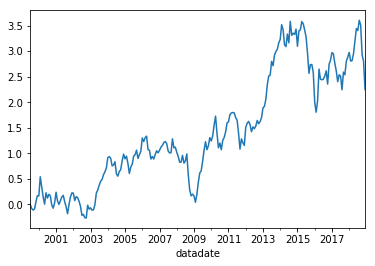

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.170697
2000-12-31   -0.119417
2001-12-31    0.187379
2002-12-31   -0.259090
2003-12-31    0.887299
2004-12-31    0.158886
2005-12-31    0.027240
2006-12-31   -0.014346
2007-12-31    0.055917
2008-12-31   -0.433566
2009-12-31    0.920498
2010-12-31    0.124857
2011-12-31   -0.169737
2012-12-31    0.252476
2013-12-31    0.543146
2014-12-31    0.064092
2015-12-31   -0.191578
2016-12-31    0.066996
2017-12-31    0.016022
2018-12-31   -0.163603
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     222.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.32e-77
Time:                        21:22:58   Log-Likelihood:                 435.97
No. Observations:                 234   AIC:                            -861.9
Df Residuals:                     229   BIC:                            -844.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.003      1.625      0.106      -0.001       0.009
mktrf          0.8928      0.071     12.611      0.000       0.753       1.032
me             0.9245      0.082     11.226      0.000       0.762       1.087
ia             0.0822      0.125      0.657      0.512      -0.164       0.329
roe           -0.8634      0.107     -8.059      0.000      -1.074      -0.652
==============================================================================
Omnibus:                       51.928   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.831
Skew:                           1.008   Prob(JB):                     2.88e-28
Kurtosis:                       5.991   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     197.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.12e-73
Time:                        21:22:58   Log-Likelihood:                 435.97
No. Observations:                 234   AIC:                            -861.9
Df Residuals:                     229   BIC:                            -844.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.003      1.663      0.096      -0.001       0.009
mktrf          0.8928      0.078     11.492      0.000       0.741       1.045
me             0.9245      0.099      9.372      0.000       0.731       1.118
ia             0.0822      0.171      0.479      0.632      -0.254       0.418
roe           -0.8634      0.185     -4.672      0.000      -1.226      -0.501
==============================================================================
Omnibus:                       51.928   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.831
Skew:                           1.008   Prob(JB):                     2.88e-28
Kurtosis:                       5.991   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     202.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.82e-74
Time:                        21:22:58   Log-Likelihood:                 435.97
No. Observations:                 234   AIC:                            -861.9
Df Residuals:                     229   BIC:                            -844.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.003      1.599      0.110      -0.001       0.009
mktrf          0.8928      0.080     11.117      0.000       0.735       1.050
me             0.9245      0.111      8.311      0.000       0.706       1.143
ia             0.0822      0.161      0.510      0.610      -0.234       0.398
roe           -0.8634      0.203     -4.250      0.000      -1.261      -0.465
==============================================================================
Omnibus:                       51.928   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.831
Skew:                           1.008   Prob(JB):                     2.88e-28
Kurtosis:                       5.991   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     177.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.16e-76
Time:                        21:22:58   Log-Likelihood:                 435.94
No. Observations:                 234   AIC:                            -859.9
Df Residuals:                     228   BIC:                            -839.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.003      1.231      0.220      -0.002       0.008
mktrf          1.0055      0.071     14.141      0.000       0.865       1.146
smb            0.9816      0.094     10.464      0.000       0.797       1.166
hml           -0.0379      0.111     -0.343      0.732      -0.256       0.180
rmw           -0.7316      0.125     -5.849      0.000      -0.978      -0.485
cma            0.2872      0.159      1.807      0.072      -0.026       0.600
==============================================================================
Omnibus:                       67.105   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              187.745
Skew:                           1.247   Prob(JB):                     1.71e-41
Kurtosis:                       6.611   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     262.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.10e-92
Time:                        21:22:58   Log-Likelihood:                 435.94
No. Observations:                 234   AIC:                            -859.9
Df Residuals:                     228   BIC:                            -839.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.003      1.220      0.222      -0.002       0.008
mktrf          1.0055      0.066     15.259      0.000       0.876       1.135
smb            0.9816      0.100      9.812      0.000       0.786       1.178
hml           -0.0379      0.170     -0.223      0.823      -0.371       0.295
rmw           -0.7316      0.199     -3.677      0.000      -1.121      -0.342
cma            0.2872      0.220      1.308      0.191      -0.143       0.718
==============================================================================
Omnibus:                       67.105   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              187.745
Skew:                           1.247   Prob(JB):                     1.71e-41
Kurtosis:                       6.611   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     244.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.54e-89
Time:                        21:22:58   Log-Likelihood:                 435.94
No. Observations:                 234   AIC:                            -859.9
Df Residuals:                     228   BIC:                            -839.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.003      1.178      0.239      -0.002       0.009
mktrf          1.0055      0.068     14.689      0.000       0.871       1.140
smb            0.9816      0.106      9.255      0.000       0.774       1.190
hml           -0.0379      0.171     -0.222      0.825      -0.373       0.298
rmw           -0.7316      0.221     -3.311      0.001      -1.165      -0.299
cma            0.2872      0.211      1.361      0.174      -0.127       0.701
==============================================================================
Omnibus:                       67.105   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              187.745
Skew:                           1.247   Prob(JB):                     1.71e-41
Kurtosis:                       6.611   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     201.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.49e-74
Time:                        21:22:58   Log-Likelihood:                 427.12
No. Observations:                 234   AIC:                            -844.2
Df Residuals:                     229   BIC:                            -827.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.003      0.548      0.584      -0.004       0.007
mktrf          1.0532      0.068     15.559      0.000       0.920       1.187
smb            1.2917      0.085     15.287      0.000       1.125       1.458
hml            0.0244      0.084      0.290      0.772      -0.141       0.190
umd           -0.2224      0.055     -4.038      0.000      -0.331      -0.114
==============================================================================
Omnibus:                       70.363   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              257.255
Skew:                           1.199   Prob(JB):                     1.37e-56
Kurtosis:                       7.542   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     193.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.65e-72
Time:                        21:22:58   Log-Likelihood:                 427.12
No. Observations:                 234   AIC:                            -844.2
Df Residuals:                     229   BIC:                            -827.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.002      0.601      0.548      -0.003       0.006
mktrf          1.0532      0.055     19.058      0.000       0.945       1.162
smb            1.2917      0.091     14.201      0.000       1.113       1.470
hml            0.0244      0.129      0.189      0.850      -0.228       0.276
umd           -0.2224      0.081     -2.753      0.006      -0.381      -0.064
==============================================================================
Omnibus:                       70.363   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              257.255
Skew:                           1.199   Prob(JB):                     1.37e-56
Kurtosis:                       7.542   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     190.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.04e-71
Time:                        21:22:58   Log-Likelihood:                 427.12
No. Observations:                 234   AIC:                            -844.2
Df Residuals:                     229   BIC:                            -827.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.002      0.589      0.556      -0.003       0.006
mktrf          1.0532      0.052     20.291      0.000       0.951       1.155
smb            1.2917      0.096     13.463      0.000       1.104       1.480
hml            0.0244      0.120      0.202      0.840      -0.212       0.260
umd           -0.2224      0.090     -2.484      0.013      -0.398      -0.047
==============================================================================
Omnibus:                       70.363   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              257.255
Skew:                           1.199   Prob(JB):                     1.37e-56
Kurtosis:                       7.542   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     120.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.78e-40
Time:                        21:22:58   Log-Likelihood:                 207.50
No. Observations:                 120   AIC:                            -405.0
Df Residuals:                     115   BIC:                            -391.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0075      0.004      1.800      0.074      -0.001       0.016
mktrf          0.9202      0.113      8.141      0.000       0.696       1.144
me             1.0080      0.112      9.028      0.000       0.787       1.229
ia            -0.0584      0.175     -0.334      0.739      -0.405       0.288
roe           -0.7372      0.155     -4.764      0.000      -1.044      -0.431
==============================================================================
Omnibus:                       30.450   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.922
Skew:                           1.030   Prob(JB):                     1.32e-14
Kurtosis:                       5.922   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     173.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.94e-48
Time:                        21:22:58   Log-Likelihood:                 207.50
No. Observations:                 120   AIC:                            -405.0
Df Residuals:                     115   BIC:                            -391.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0075      0.004      1.858      0.063      -0.000       0.016
mktrf          0.9202      0.129      7.121      0.000       0.667       1.174
me             1.0080      0.124      8.101      0.000       0.764       1.252
ia            -0.0584      0.241     -0.242      0.809      -0.531       0.414
roe           -0.7372      0.264     -2.795      0.005      -1.254      -0.220
==============================================================================
Omnibus:                       30.450   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.922
Skew:                           1.030   Prob(JB):                     1.32e-14
Kurtosis:                       5.922   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     180.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.30e-48
Time:                        21:22:59   Log-Likelihood:                 207.50
No. Observations:                 120   AIC:                            -405.0
Df Residuals:                     115   BIC:                            -391.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0075      0.004      1.770      0.077      -0.001       0.016
mktrf          0.9202      0.141      6.531      0.000       0.644       1.196
me             1.0080      0.136      7.419      0.000       0.742       1.274
ia            -0.0584      0.218     -0.268      0.789      -0.485       0.369
roe           -0.7372      0.295     -2.499      0.012      -1.315      -0.159
==============================================================================
Omnibus:                       30.450   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.922
Skew:                           1.030   Prob(JB):                     1.32e-14
Kurtosis:                       5.922   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     108.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.05e-41
Time:                        21:22:59   Log-Likelihood:                 213.90
No. Observations:                 120   AIC:                            -415.8
Df Residuals:                     114   BIC:                            -399.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0078      0.004      1.900      0.060      -0.000       0.016
mktrf          1.1148      0.113      9.822      0.000       0.890       1.340
smb            1.0937      0.129      8.508      0.000       0.839       1.348
hml           -0.2230      0.158     -1.415      0.160      -0.535       0.089
rmw           -0.5206      0.186     -2.802      0.006      -0.889      -0.153
cma            0.3504      0.203      1.722      0.088      -0.053       0.754
==============================================================================
Omnibus:                       29.512   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.371
Skew:                           1.053   Prob(JB):                     9.47e-13
Kurtosis:                       5.577   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     331.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.03e-66
Time:                        21:22:59   Log-Likelihood:                 213.90
No. Observations:                 120   AIC:                            -415.8
Df Residuals:                     114   BIC:                            -399.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0078      0.004      1.981      0.048    8.44e-05       0.015
mktrf          1.1148      0.100     11.164      0.000       0.919       1.311
smb            1.0937      0.125      8.766      0.000       0.849       1.338
hml           -0.2230      0.228     -0.977      0.328      -0.670       0.224
rmw           -0.5206      0.287     -1.811      0.070      -1.084       0.043
cma            0.3504      0.263      1.332      0.183      -0.165       0.866
==============================================================================
Omnibus:                       29.512   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.371
Skew:                           1.053   Prob(JB):                     9.47e-13
Kurtosis:                       5.577   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     444.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.17e-73
Time:                        21:22:59   Log-Likelihood:                 213.90
No. Observations:                 120   AIC:                            -415.8
Df Residuals:                     114   BIC:                            -399.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0078      0.004      1.857      0.063      -0.000       0.016
mktrf          1.1148      0.109     10.211      0.000       0.901       1.329
smb            1.0937      0.122      8.980      0.000       0.855       1.332
hml           -0.2230      0.239     -0.934      0.350      -0.691       0.245
rmw           -0.5206      0.328     -1.586      0.113      -1.164       0.123
cma            0.3504      0.243      1.444      0.149      -0.125       0.826
==============================================================================
Omnibus:                       29.512   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.371
Skew:                           1.053   Prob(JB):                     9.47e-13
Kurtosis:                       5.577   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     128.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.58e-41
Time:                        21:22:59   Log-Likelihood:                 210.83
No. Observations:                 120   AIC:                            -411.7
Df Residuals:                     115   BIC:                            -397.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.004      1.571      0.119      -0.002       0.014
mktrf          1.1048      0.097     11.406      0.000       0.913       1.297
smb            1.3439      0.110     12.186      0.000       1.125       1.562
hml           -0.0531      0.110     -0.481      0.632      -0.272       0.166
umd           -0.1991      0.068     -2.924      0.004      -0.334      -0.064
==============================================================================
Omnibus:                       37.668   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               94.744
Skew:                           1.196   Prob(JB):                     2.67e-21
Kurtosis:                       6.637   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     318.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.35e-61
Time:                        21:22:59   Log-Likelihood:                 210.83
No. Observations:                 120   AIC:                            -411.7
Df Residuals:                     115   BIC:                            -397.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.003      2.179      0.029       0.001       0.012
mktrf          1.1048      0.064     17.327      0.000       0.980       1.230
smb            1.3439      0.118     11.407      0.000       1.113       1.575
hml           -0.0531      0.188     -0.282      0.778      -0.422       0.316
umd           -0.1991      0.086     -2.327      0.020      -0.367      -0.031
==============================================================================
Omnibus:                       37.668   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               94.744
Skew:                           1.196   Prob(JB):                     2.67e-21
Kurtosis:                       6.637   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     320.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.38e-61
Time:                        21:22:59   Log-Likelihood:                 210.83
No. Observations:                 120   AIC:                            -411.7
Df Residuals:                     115   BIC:                            -397.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.003      2.354      0.019       0.001       0.012
mktrf          1.1048      0.057     19.271      0.000       0.992       1.217
smb            1.3439      0.113     11.911      0.000       1.123       1.565
hml           -0.0531      0.188     -0.282      0.778      -0.422       0.316
umd           -0.1991      0.095     -2.105      0.035      -0.385      -0.014
==============================================================================
Omnibus:                       37.668   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               94.744
Skew:                           1.196   Prob(JB):                     2.67e-21
Kurtosis:                       6.637   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     107.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.13e-37
Time:                        21:22:59   Log-Likelihood:                 243.17
No. Observations:                 114   AIC:                            -476.3
Df Residuals:                     109   BIC:                            -462.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.003     -0.076      0.940      -0.006       0.006
mktrf          0.9741      0.086     11.301      0.000       0.803       1.145
me             0.5778      0.133      4.341      0.000       0.314       0.842
ia             0.3286      0.185      1.780      0.078      -0.037       0.694
roe           -1.1403      0.162     -7.030      0.000      -1.462      -0.819
==============================================================================
Omnibus:                       24.570   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.443
Skew:                           0.999   Prob(JB):                     4.49e-09
Kurtosis:                       5.025   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     181.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.22e-47
Time:                        21:22:59   Log-Likelihood:                 243.17
No. Observations:                 114   AIC:                            -476.3
Df Residuals:                     109   BIC:                            -462.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.002     -0.101      0.920      -0.005       0.004
mktrf          0.9741      0.067     14.617      0.000       0.843       1.105
me             0.5778      0.136      4.258      0.000       0.312       0.844
ia             0.3286      0.228      1.442      0.149      -0.118       0.775
roe           -1.1403      0.268     -4.256      0.000      -1.665      -0.615
==============================================================================
Omnibus:                       24.570   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.443
Skew:                           0.999   Prob(JB):                     4.49e-09
Kurtosis:                       5.025   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     213.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.38e-50
Time:                        21:22:59   Log-Likelihood:                 243.17
No. Observations:                 114   AIC:                            -476.3
Df Residuals:                     109   BIC:                            -462.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.002     -0.116      0.908      -0.004       0.004
mktrf          0.9741      0.055     17.707      0.000       0.866       1.082
me             0.5778      0.148      3.907      0.000       0.288       0.868
ia             0.3286      0.244      1.346      0.178      -0.150       0.807
roe           -1.1403      0.256     -4.446      0.000      -1.643      -0.638
==============================================================================
Omnibus:                       24.570   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.443
Skew:                           0.999   Prob(JB):                     4.49e-09
Kurtosis:                       5.025   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     67.74
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.04e-31
Time:                        21:22:59   Log-Likelihood:                 232.91
No. Observations:                 114   AIC:                            -453.8
Df Residuals:                     108   BIC:                            -437.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.003     -0.807      0.422      -0.009       0.004
mktrf          1.0246      0.090     11.339      0.000       0.845       1.204
smb            0.6886      0.147      4.694      0.000       0.398       0.979
hml            0.2592      0.187      1.386      0.169      -0.112       0.630
rmw           -0.8178      0.229     -3.570      0.001      -1.272      -0.364
cma            0.1331      0.291      0.458      0.648      -0.443       0.710
==============================================================================
Omnibus:                       46.912   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              158.397
Skew:                           1.431   Prob(JB):                     4.02e-35
Kurtosis:                       8.015   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     99.69
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.91e-39
Time:                        21:22:59   Log-Likelihood:                 232.91
No. Observations:                 114   AIC:                            -453.8
Df Residuals:                     108   BIC:                            -437.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.003     -0.987      0.324      -0.008       0.003
mktrf          1.0246      0.076     13.420      0.000       0.875       1.174
smb            0.6886      0.135      5.096      0.000       0.424       0.953
hml            0.2592      0.152      1.709      0.087      -0.038       0.557
rmw           -0.8178      0.350     -2.339      0.019      -1.503      -0.132
cma            0.1331      0.309      0.430      0.667      -0.473       0.739
==============================================================================
Omnibus:                       46.912   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              158.397
Skew:                           1.431   Prob(JB):                     4.02e-35
Kurtosis:                       8.015   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     123.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.78e-43
Time:                        21:22:59   Log-Likelihood:                 232.91
No. Observations:                 114   AIC:                            -453.8
Df Residuals:                     108   BIC:                            -437.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.002     -1.140      0.254      -0.007       0.002
mktrf          1.0246      0.081     12.630      0.000       0.866       1.184
smb            0.6886      0.159      4.321      0.000       0.376       1.001
hml            0.2592      0.161      1.607      0.108      -0.057       0.575
rmw           -0.8178      0.382     -2.139      0.032      -1.567      -0.069
cma            0.1331      0.365      0.364      0.716      -0.583       0.849
==============================================================================
Omnibus:                       46.912   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              158.397
Skew:                           1.431   Prob(JB):                     4.02e-35
Kurtosis:                       8.015   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     77.14
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.69e-31
Time:                        21:22:59   Log-Likelihood:                 228.55
No. Observations:                 114   AIC:                            -447.1
Df Residuals:                     109   BIC:                            -433.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0032      0.003     -0.956      0.341      -0.010       0.003
mktrf          1.0522      0.093     11.331      0.000       0.868       1.236
smb            0.8740      0.145      6.036      0.000       0.587       1.161
hml            0.3569      0.149      2.394      0.018       0.061       0.652
umd           -0.2496      0.112     -2.218      0.029      -0.473      -0.027
==============================================================================
Omnibus:                       43.746   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              182.178
Skew:                           1.225   Prob(JB):                     2.76e-40
Kurtosis:                       8.688   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     153.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.94e-44
Time:                        21:22:59   Log-Likelihood:                 228.55
No. Observations:                 114   AIC:                            -447.1
Df Residuals:                     109   BIC:                            -433.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0032      0.003     -1.056      0.291      -0.009       0.003
mktrf          1.0522      0.080     13.203      0.000       0.896       1.208
smb            0.8740      0.120      7.293      0.000       0.639       1.109
hml            0.3569      0.150      2.376      0.018       0.063       0.651
umd           -0.2496      0.094     -2.657      0.008      -0.434      -0.065
==============================================================================
Omnibus:                       43.746   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              182.178
Skew:                           1.225   Prob(JB):                     2.76e-40
Kurtosis:                       8.688   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     156.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.08e-44
Time:                        21:22:59   Log-Likelihood:                 228.55
No. Observations:                 114   AIC:                            -447.1
Df Residuals:                     109   BIC:                            -433.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0032      0.003     -1.080      0.280      -0.009       0.003
mktrf          1.0522      0.081     12.981      0.000       0.893       1.211
smb            0.8740      0.108      8.087      0.000       0.662       1.086
hml            0.3569      0.143      2.500      0.012       0.077       0.637
umd           -0.2496      0.075     -3.329      0.001      -0.397      -0.103
==============================================================================
Omnibus:                       43.746   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              182.178
Skew:                           1.225   Prob(JB):                     2.76e-40
Kurtosis:                       8.688   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""